In [247]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import scipy.signal as signal
from tflearn.layers.core import fully_connected
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re
%matplotlib inline

## Data acquisition

Load the data.

In [3]:
data_dir = 'data'
files = os.listdir(data_dir)
df = pd.DataFrame(columns=['record', 'distance', 'speed'])

def get_record(distance, speed):
    
    return df['record'][ (df['distance'] == distance) & (df['speed'] == speed) ].tolist()[0]


for f in files:
    if '.wav' not in f:
        continue
    fs, data = wav.read(os.path.join(data_dir, f))
    decoded_classes = [ int(s) for s in re.findall(r'-?\d+', f) ]
    # put the data into the DataFrame
    df = df.append(dict(
        { 'record'   : np.divide(data, np.max(data)), 
          'distance' : decoded_classes[0],
          'speed'    : decoded_classes[1] }), ignore_index=True)
    
DISTANCES = sorted(df.distance.unique())
SPEEDS = sorted(df.speed.unique())

### Exploration of raw data

Plot several raw signals for several speeds and distances.

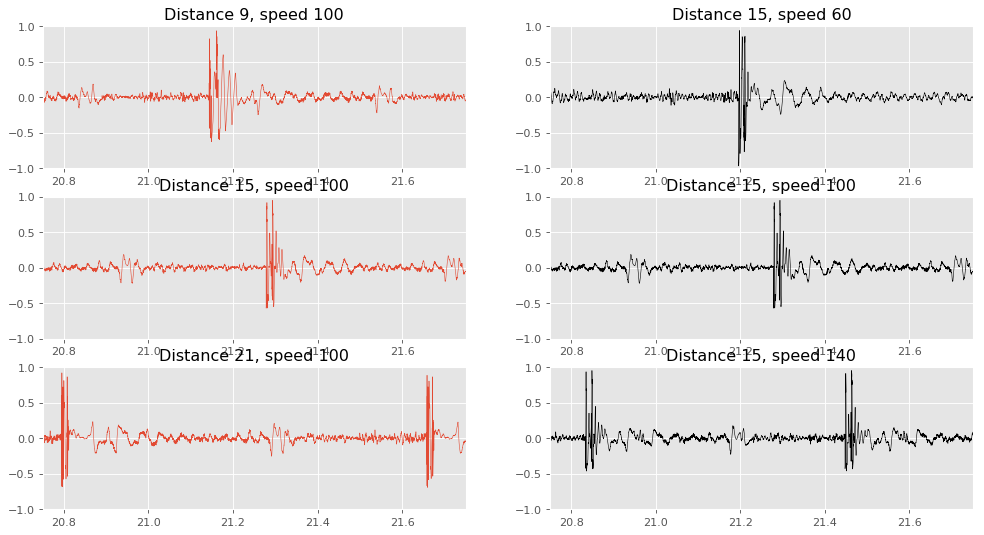

In [4]:
plt.figure(num=None, figsize=(15, 8), dpi=80)
plt.style.use('ggplot')

PLT_DISTANCE = 15
PLT_SPEED = 100

# plot for varying speed
for speed in range(60, 150, 40):
    data = get_record(PLT_DISTANCE, speed)
    plt.subplot(3, 2, int(speed / 40) * 2)
    timeline = np.linspace(0, len(data) / 44100., len(data))
    plt.plot(timeline, data, color='k', linewidth=.5)
    plt.xlim((20.75, 21.75))
    plt.ylim((-1, 1))
    plt.title('Distance %d, speed %d' % (PLT_DISTANCE, speed))
    
# plot for varying distance
for distance in range(9, 22, 6):
    data = get_record(distance, PLT_SPEED)
    plt.subplot(3, 2, int(distance / 7) * 2 - 1)
    timeline = np.linspace(0, len(data) / 44100., len(data))
    plt.plot(timeline, data, linewidth=.5)
    plt.xlim((20.75, 21.75))
    plt.ylim((-1, 1))
    plt.title('Distance %d, speed %d' % (distance, PLT_SPEED))

## Finding peaks

In [50]:
EXPECTED_CONTACTS = 100
THRESHOLD = .6 #1844146018536
FRAGMENT_SIZE = 2048
SAMPLES_BETWEEN_CONTACTS = 8192

def find_peaks(x, method='last_peaks'):
    above_th = pd.Series(x) > THRESHOLD
    # find every threshold transgression
    above_th = pd.Series(above_th.index[above_th == True].tolist()).astype(int)
    diff = above_th.diff(periods=-1).abs()
    if method == 'first_peaks':
        diff = diff.shift(1).fillna(SAMPLES_BETWEEN_CONTACTS)
    peaks_indices = diff.index[diff >= SAMPLES_BETWEEN_CONTACTS].tolist()
    peaks_indices.append(len(above_th) - 1)
    peaks = above_th[peaks_indices].reset_index(drop=True)
    return peaks

def extract_peaks(d, peaks):
    idx_peaks = pd.Index(peaks)
    contacts = []
    for c_idx in peaks:
        contacts.append(d[c_idx:c_idx + FRAGMENT_SIZE].tolist())
    return contacts

In [51]:
contact_signals = pd.DataFrame()

for i in range(len(df)):
    speed = df.at[i, 'speed']
    distance = df.at[i, 'distance']
    d = pd.Series(df.at[i, 'record'])
    peaks = find_peaks(d.abs())
    if len(peaks) != EXPECTED_CONTACTS:
        print('Unexpected amount of contacts (%d) in set distance %d - speed %d' 
              % (len(peaks), distance, speed))
    contacts = extract_peaks(d, peaks)
    contact_signals = contact_signals.append([[speed, distance] + contacts], ignore_index=True)
    
contact_signals.rename(columns={ 0 : 'speed', 1 : 'distance' }, inplace=True)
last_col = contact_signals.columns[-1]
contact_signals.rename(columns=dict(zip(range(2, last_col), range(0, last_col-2))), inplace=True)
contact_signals.rename(columns={ 101 : 99 }, inplace=True)

Unexpected amount of contacts (99) in set distance 5 - speed 160
Unexpected amount of contacts (99) in set distance 7 - speed 160


/media/luca/LocalDiskAsWell/python_projects/venv/lib/python3.5/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


array([[ 0.61915519,  0.58186972,  0.5508624 , ..., -0.03913705,
        -0.03961798, -0.04020712]])

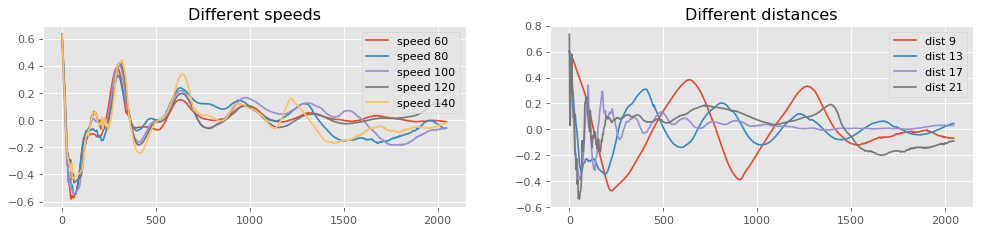

In [52]:
plt.figure(num=None, figsize=(15, 3), dpi=80)
plt.subplot(1, 2, 1)
for speed in range(60, 150, 20): 
    data = contact_signals[10][ (contact_signals['distance'] == PLT_DISTANCE) 
                               & (contact_signals['speed'] == speed) ].tolist()[0]
    plt.plot(data, label='speed %d' % speed)
    plt.title('Different speeds')
plt.legend()
plt.subplot(1, 2, 2)  
for distance in range(9, 22, 4):
    data = contact_signals[10][ (contact_signals['distance'] == distance) 
                               & (contact_signals['speed'] == PLT_SPEED) ].tolist()[0]
    plt.plot(data, label='dist %d' % distance)
    plt.title('Different distances')
plt.legend()
np.mean(contact_signals.loc[(contact_signals['distance'] == PLT_DISTANCE) 
                               & (contact_signals['speed'] == speed)].iloc[:, 2:99].values.tolist(), axis=1)

/media/luca/LocalDiskAsWell/python_projects/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.5/dist-packages/matplotlib/transforms.py:737: RuntimeWarning: invalid value encountered in maximum
  x0 = np.maximum(bbox1.xmin, bbox2.xmin)
/usr/local/lib/python3.5/dist-packages/matplotlib/transforms.py:738: RuntimeWarning: invalid value encountered in minimum
  x1 = np.minimum(bbox1.xmax, bbox2.xmax)
/usr/local/lib/python3.5/dist-packages/matplotlib/transforms.py:739: RuntimeWarning: invalid value encountered in maximum
  y0 = np.maximum(bbox1.ymin, bbox2.ymin)
/usr/local/lib/python3.5/dist-packages/matplotlib/transforms.py:740: RuntimeWarning: invalid value encountered in minimum
  y1 = np.minimum(bbox1.ymax, bbox2.ymax)


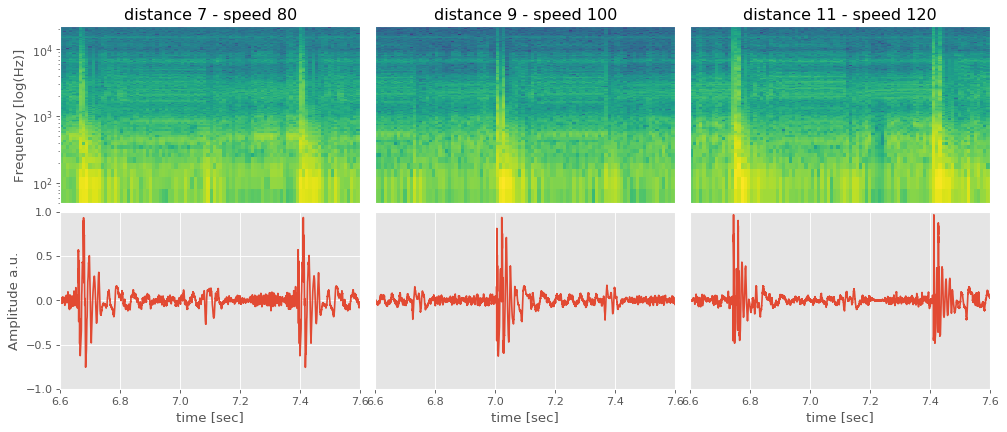

In [20]:
import matplotlib.gridspec as gridspec

fig = plt.figure(num=None, figsize=(15, 6), dpi=80)
outer = gridspec.GridSpec(1, 3, wspace=0.05, hspace=0.2)

SEGMENT_LEN = 535
FRAMERATE = 44100.

def generate_spectrogram(data):
    '''
    Generates a spectrogram with logarithmically scaled frequency dimension.
    '''
    f, t, Sxx = signal.spectrogram(data, fs=FRAMERATE, scaling='density', mode='psd', nperseg=SEGMENT_LEN, 
                                 nfft=SEGMENT_LEN*2)
    Sxx = np.log(Sxx)
    return f, t, Sxx

for i in range(3):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0.2, hspace=0.05)
    ax = plt.Subplot(fig, inner[0])
    ax.set_title("distance %d - speed %d" % (i * 2 + 7, i * 20 + 80))
    if i == 0:
        ax.set_ylabel("Frequency [log(Hz)]")
    else:
        ax.get_yaxis().set_visible(False)
    dat = get_record(i * 2 + 7, i * 20 + 80)
    f, t, Sxx = generate_spectrogram(dat)
    timeline = np.linspace(0, len(dat) / 44100., len(dat))
    ax.pcolormesh(t, f, Sxx, label='spectrogram')
    ax.set_yscale('log')
    ax.set_ylim((50, 22050))
    ax.get_xaxis().set_visible(False)
    # show two seconds of the signals spectrogram
    ax.set_xlim((6.6, 7.6))
    fig.add_subplot(ax)
    
    ax = plt.Subplot(fig, inner[1])
    ax.set_xlim((6.6, 7.6))
    ax.set_ylim((-1., 1.))
    ax.set_xlabel("time [sec]")
    if i == 0:
        ax.set_ylabel("Amplitude a.u.")
    else:
        ax.get_yaxis().set_ticks([])
    # plot raw signal
    ax.plot(timeline, dat)
    fig.add_subplot(ax)

In [73]:
from sklearn.manifold import TSNE

# scale data
contacts = contact_signals.iloc[:, 2:].dropna().values.tolist()
contacts = np.reshape(contacts, [61 * 100, 2048])
#X_train, X_test, y_train, y_test = train_test_split(contacts, y, test_size=test_percentage, random_state=42)

tsne = TSNE(n_components=2, random_state=0)
#x_test_2d = tsne.fit_transform(contacts)
np.shape(contact_signals[contact_signals.distance == 11].iloc[:, 2:].values[0][0])

(6100, 2048)
(2048,)
()


(2048,)

In [82]:
FRAMERATE = 44100.
SEGMENT_LEN = 1024

def generate_spectrum(data):
    return signal.welch(data,
                           fs=FRAMERATE,
                           window='hann',
                           nperseg=SEGMENT_LEN,
                           nfft=SEGMENT_LEN*2)
contact_signals

,speed,distance,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,100,11,"[0.6034554711626743, 0.5998664552207662, 0.596...","[0.611885485351807, 0.599699524246724, 0.58125...","[0.6015357649611885, 0.5962774392788582, 0.590...","[0.6123028127869126, 0.5996160587597028, 0.586...","[0.6107169685335114, 0.5958601118437526, 0.582...","[0.6184792588264753, 0.5995325932726817, 0.587...","[0.6183957933394542, 0.5986979384024705, 0.584...","[0.6001168516818296, 0.5864285118103664, 0.572...",...,"[0.611134295968617, 0.5950254569735415, 0.5842...","[0.6001168516818296, 0.5878474250897254, 0.579...","[-0.6030381437275687, -0.5993656622986395, -0....","[0.6155579667807362, 0.599031800350555, 0.5853...","[0.6083799348969201, 0.5943577330773725, 0.585...","[0.6002837826558718, 0.5840914781737752, 0.571...","[0.6124697437609549, 0.5981136799933228, 0.587...","[0.609715382689258, 0.5956931808697103, 0.5859...","[-0.6010349720390619, -0.5991152658375761, -0....","[0.6008680410650196, 0.5973624906101327, 0.593..."
1,120,11,"[0.6189635696131036, 0.5920643885907936, 0.560...","[0.6015955944648405, 0.5733549844676645, 0.541...","[0.6109149957639085, 0.5610703191188929, 0.528...","[0.6349195142615081, 0.5948884495905111, 0.562...","[0.6087263484891273, 0.572790172267721, 0.5489...","[0.6176927421632308, 0.5720841570177916, 0.529...","[0.6305422197119458, 0.5898051397910195, 0.556...","[0.6272945495622706, 0.5951708556904829, 0.568...",...,"[0.6139508613386049, 0.5780852866421915, 0.551...","[0.6133154476136684, 0.5700367127929963, 0.530...","[0.6071025134142898, 0.5613527252188647, 0.517...","[0.602089805139791, 0.5547867833945214, 0.5053...","[0.630330415136967, 0.5917113809658289, 0.5461...","[0.6015249929398475, 0.5670714487432928, 0.543...","[0.6074555210392545, 0.5648828014685118, 0.530...","[0.6110561988138944, 0.5666478395933352, 0.527...","[0.6198813894380119, 0.5866280711663372, 0.538...","[0.602089805139791, 0.5733549844676645, 0.5588..."
2,140,11,"[0.6155064254826725, 0.5749436628296486, 0.525...","[0.6000365430294171, 0.5793897314087337, 0.579...","[0.6096595407759303, 0.5803033071441622, 0.565...","[0.6128875083744443, 0.5832267494975334, 0.556...","[0.605091662098788, 0.5818868384189049, 0.5715...","[0.608441439795359, 0.5815823131737621, 0.5574...","[0.6114866922467873, 0.5797551617029052, 0.550...","[0.600889213715817, 0.5728119861136488, 0.5486...",...,"[0.6203179243559291, 0.5901090200377611, 0.550...","[0.6099031609720446, 0.5840794201839332, 0.567...","[0.622997746513186, 0.5938851330775321, 0.5614...","[0.6061270479322736, 0.5754309032218771, 0.544...","[0.6188562031792436, 0.58675924234119, 0.55581...","[0.6230586515622145, 0.5942505633717036, 0.565...","[0.6021682197454169, 0.5706194043486205, 0.539...","[0.6201352092088435, 0.5944941835678178, 0.568...","[0.6032036055789025, 0.5759181436141056, 0.546...","[0.6262257141116998, 0.5959559047445033, 0.565..."
3,160,11,"[0.6121427710116966, 0.5800675268298565, 0.553...","[0.6027975400940552, 0.5813336548896659, 0.566...","[0.6229350054262631, 0.5978536114795611, 0.571...","[0.6091281803931026, 0.5891112986856385, 0.556...","[0.6122633546364403, 0.5845894127577475, 0.558...","[0.6093090558302182, 0.5873025443144821, 0.559...","[0.6146750271313156, 0.5955022307970578, 0.568...","[0.6042445435909803, 0.5782587724587, 0.555167...",...,"[0.6080429277704088, 0.5848908718196069, 0.562...","[0.6138309417581093, 0.59942119860123, 0.57638...","[0.6092487640178463, 0.586337875316532, 0.5654...","[0.6168455323767033, 0.596888942481611, 0.5736...","[0.6057518389002774, 0.588870131436151, 0.5651...","[0.6043651272157241, 0.5801881104546003, 0.559...","[0.6117207283250935, 0.588327505124804, 0.5662...","[0.6021946219703365, 0.5781984806463283, 0.559...","[0.604907753527071, 0.5813939467020378, 0.5616...","[0.6008079102857832, 0.5769926443988906, 0.559..."
4,180,11,"[0.6053947838513755, 0.5775276884601643, 0.557...","[0.6116470167917113, 0.5912826009289032, 0.575...","[0.6000952721209956, 0.5

In [204]:
# save all spectra to a DataFrame
psds = pd.DataFrame()
clean_contact_data = contact_signals.iloc[:, :101]

for i in range(len(df)):
    speed = clean_contact_data.at[i, 'speed']
    distance = clean_contact_data.at[i, 'distance']
    contact_data = clean_contact_data.iloc[i, 2:].values.tolist()
    # generate spectra for all every contact of this speed and distance
    f, Pxx = generate_spectrum(contact_data)
    Pxx = 10 * np.log10(Pxx)
    Pxx = [ np.append([distance, speed], pxx) for pxx in Pxx ]
    psds = psds.append(Pxx)

psds.columns = np.append(['distance', 'speed'], np.array(f, dtype=np.float))
psds.head()

,distance,speed,0.0,21.533203125,43.06640625,64.599609375,86.1328125,107.666015625,129.19921875,150.732421875,...,21856.201171875,21877.734375,21899.267578125,21920.80078125,21942.333984375,21963.8671875,21985.400390625,22006.93359375,22028.466796875,22050.0
0,11.0,100.0,-47.385818,-40.868204,-36.024437,-33.272775,-32.820579,-34.510282,-37.993277,-42.153614,...,-129.873410,-131.610849,-131.550733,-129.619492,-128.262721,-128.441297,-130.234276,-133.021642,-135.812267,-140.386897
1,11.0,100.0,-37.030877,-33.100519,-31.857285,-31.661994,-32.436929,-33.379718,-34.044734,-34.953406,...,-115.910960,-116.057782,-116.517985,-116.361750,-115.014609,-114.295198,-114.586543,-115.295527,-116.210570,-119.804129
2,11.0,100.0,-53.368848,-44.369299,-38.576933,-35.370755,-34.458924,-35.621515,-38.470268,-42.117925,...,-126.240359,-124.534778,-124.098350,-124.731521,-125.981038,-127.665592,-129.970550,-131.920012,-131.252639,-133.444091
3,11.0,100.0,-48.027620,-39.976613,-34.155922,-31.098316,-30.712151,-32.997379,-38.378914,-46.950951,...,-132.057948,-135.178927,-132.488638,-129.993692,-129.983118,-131.526570,-132.500029,-132.188322,-131.611671,-134.331760
4,11.0,100.0,-47.507738,-40.028426,-34.583539,-31.660451,-31.312357,-33.568643,-38.820233,-47.206886,...,-131.078786,-131.026629,-131.085483,-131.185807,-131.927939,-133.614735,-134.110603,-131.769703,-129.169204,-131.161503


Text(0,0.5,'Frequency power')

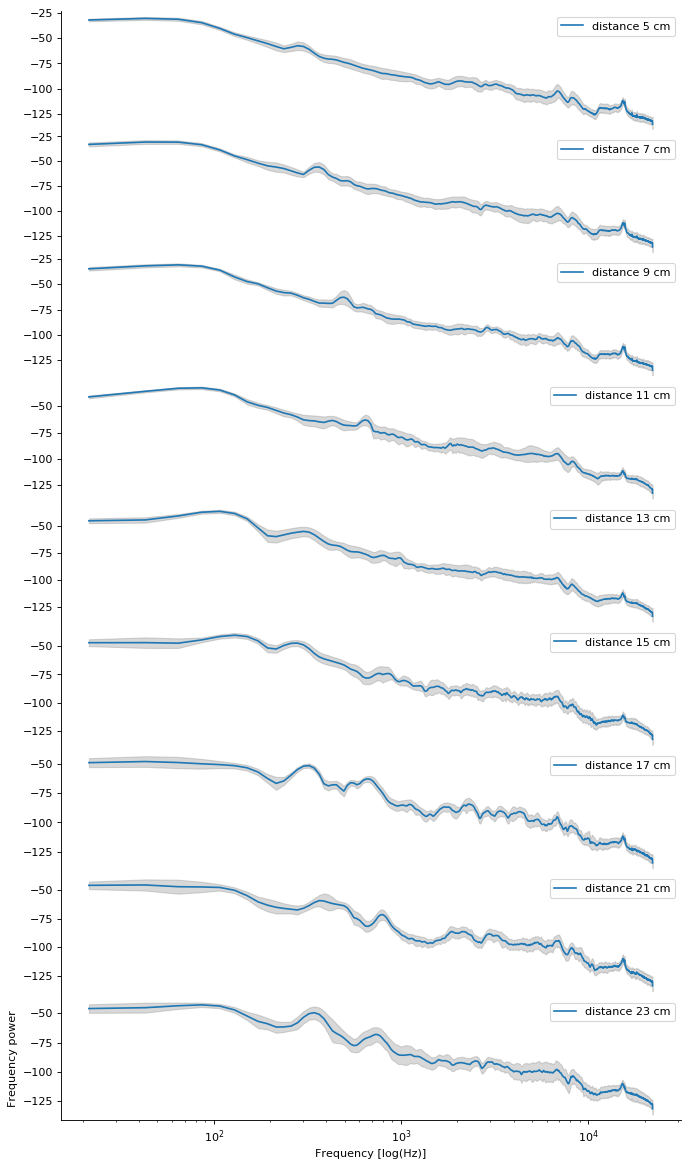

In [205]:
plt.figure(num=None, figsize=(10, 20), dpi=80)
plt.subplots_adjust(hspace=0)
counter = 1

plt.style.use('default')

for dist in psds.distance.sort_values().unique():    
    dat = psds[psds.distance == dist].iloc[:, 2:].values.tolist()
    average = np.mean(dat, axis=0)
    std_dev = np.std(dat, axis=0)
    ax = plt.subplot(10, 1, counter)
    plt.xscale('log')
    counter += 1
    
    plt.plot(f, average, label='distance %d cm' % dist)
    plt.fill_between(f, average-std_dev, average+std_dev, color='grey', alpha=.3)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if counter < 10:
        ax.spines['bottom'].set_visible(False)
        ax.get_xaxis().set_visible(False)
    plt.legend()
    
plt.legend()
plt.xlabel("Frequency [log(Hz)]")
plt.ylabel("Frequency power")

Text(0,0.5,'Frequency power')

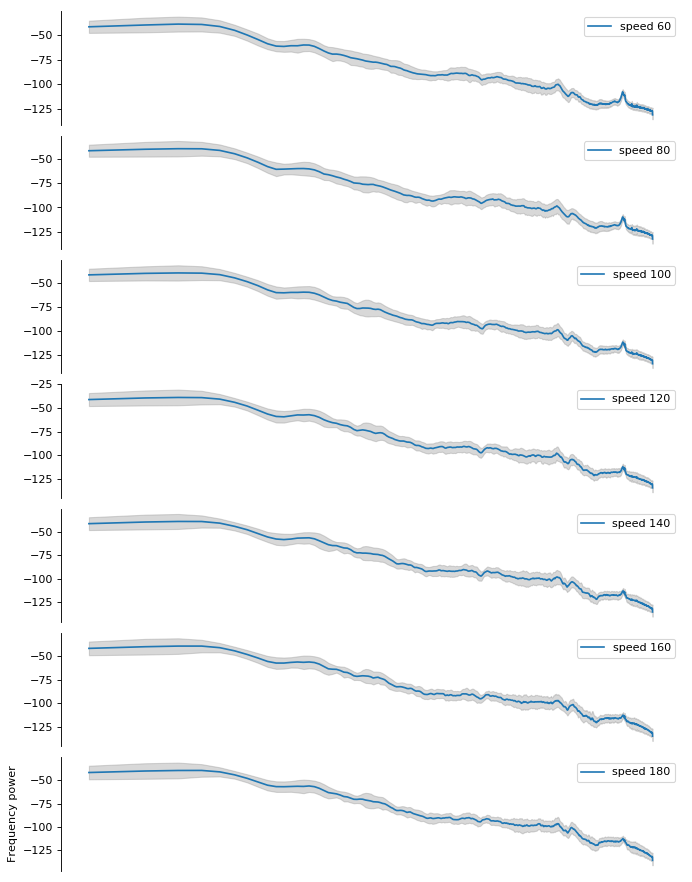

In [206]:
plt.figure(num=None, figsize=(10, 20), dpi=80)
plt.subplots_adjust(hspace=0.1)
counter = 1

for speed in psds.speed.sort_values().unique():    
    dat = psds[psds.speed == speed].iloc[:, 2:].values.tolist()
    average = np.mean(dat, axis=0)
    std_dev = np.std(dat, axis=0)
    
    ax = plt.subplot(10, 1, counter)
    plt.xscale('log')
    counter += 1
    plt.plot(f, average, label='speed %d' % speed)
    plt.fill_between(f, average-std_dev, average+std_dev, color='grey', alpha=.3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if counter < 10:
        ax.spines['bottom'].set_visible(False)
        ax.get_xaxis().set_visible(False)
    plt.legend()
    
plt.legend()
plt.xlabel("Frequency [log(Hz)]")
plt.ylabel("Frequency power")

In [245]:
# sample the frequency range in steps of 20
from joblib import Parallel


X_train, X_test, y_train, y_test = train_test_split(psds.iloc[:, 2:], psds.iloc[:, 0],random_state=42,test_size=.3)

In [263]:
cols = np.array(psds.columns[2:], dtype=np.float32)
p0 = 0
p1 = 0
prev_ret = None

def eval_score(finter):
    global p0
    global p1
    global prev_ret
    freqmid,freqw  = finter.name[0],finter.name[1]
    freqlo,freqhi  = freqmid-freqw/2.,freqmid+freqw/2.
    mask = (freqlo <= cols) & (cols <= freqhi)
    nfreq = mask.sum()
    if 0<=freqlo and freqhi<=22050 and nfreq>0:
        if p0 == cols[mask][0] and p1 == cols[mask][-1]:
            return prev_ret
        p0 = cols[mask][0]
        p1 = cols[mask][-1]
        model = SVR(kernel='rbf', epsilon=.5, C=10.)
        model.fit(X_train.iloc[:, mask], y_train)
        y_pred = model.predict(X_test.iloc[:,mask])
        y_pred = pd.Series(y_pred,index=y_test.index)
        err = y_pred - y_test
        r2_score = model.score(X_test.iloc[:,mask], y_test)
        
        perf = dict(freqlo_actual  = p0,
                    freqhi_actual  = p1,
                    freqmid_actual = (p1+p0)/2,
                    freqw_actual   = p1-p0,
                    nsv  = len(model.support_), # nb of support vectors
                    fsv  = len(model.support_)/float(y_train.count()), # fraction of support vectors
                    r2   = r2_score,
                    RMSE = np.sqrt(np.mean(err**2)), # Root-mean-square error
                    MAE  = np.mean(np.abs(err)))     # Mean absolute error
        #print(np.array(psds.columns[2:], dtype=np.float32)[mask][0])
        print('inter {:.3f}\t{:.3f}\t --> R2 = {:.5f}'.format(p0, 
                                            p1,
                                            r2_score))
    else:
        perf = dict(freqlo_actual=np.nan,freqhi_actual=np.nan,
                    freqmid_actual=np.nan,freqw_actual=np.nan,
                    nsv=np.nan,fsv=np.nan,r2=np.nan,RMSE=np.nan,MAE=np.nan)
    prev_ret = pd.Series(perf)
    return prev_ret

freqs = np.logspace(1,11,num=51,base=2)*10
fintervals = pd.MultiIndex.from_product([freqs,freqs],names=['freqmid','freqw']).to_frame(index=False)
scores = fintervals.groupby(['freqmid','freqw']).apply(eval_score)
#fintervals.groupby(['freqmid','freqw'])

inter 21.533	21.533	 --> R2 = 0.66266
inter 0.000	21.533	 --> R2 = 0.74753
inter 21.533	21.533	 --> R2 = 0.66266
inter 21.533	43.066	 --> R2 = 0.78634
inter 21.533	21.533	 --> R2 = 0.66266
inter 21.533	43.066	 --> R2 = 0.78634
inter 0.000	43.066	 --> R2 = 0.85663
inter 43.066	43.066	 --> R2 = 0.72731
inter 21.533	43.066	 --> R2 = 0.78634
inter 21.533	64.600	 --> R2 = 0.93029
inter 43.066	43.066	 --> R2 = 0.72731
inter 21.533	43.066	 --> R2 = 0.78634
inter 21.533	64.600	 --> R2 = 0.93029
inter 0.000	64.600	 --> R2 = 0.94583
inter 43.066	43.066	 --> R2 = 0.72731
inter 43.066	64.600	 --> R2 = 0.89229
inter 21.533	64.600	 --> R2 = 0.93029
inter 0.000	86.133	 --> R2 = 0.96458
inter 43.066	43.066	 --> R2 = 0.72731
inter 43.066	64.600	 --> R2 = 0.89229
inter 21.533	86.133	 --> R2 = 0.96390
inter 0.000	86.133	 --> R2 = 0.96458
inter 64.600	64.600	 --> R2 = 0.69169
inter 43.066	64.600	 --> R2 = 0.89229
inter 43.066	86.133	 --> R2 = 0.93892
inter 21.533	86.133	 --> R2 = 0.96390
inter 21.533	107.

inter 258.398	861.328	 --> R2 = 0.73417
inter 193.799	904.395	 --> R2 = 0.68756
inter 150.732	968.994	 --> R2 = 0.65166
inter 86.133	1033.594	 --> R2 = 0.63930
inter 0.000	1098.193	 --> R2 = 0.62551
inter 645.996	645.996	 --> R2 = 0.01042
inter 624.463	645.996	 --> R2 = 0.14593
inter 624.463	667.529	 --> R2 = 0.30953
inter 602.930	667.529	 --> R2 = 0.43362
inter 602.930	689.062	 --> R2 = 0.50773
inter 581.396	689.062	 --> R2 = 0.54430
inter 581.396	710.596	 --> R2 = 0.62623
inter 559.863	710.596	 --> R2 = 0.64722
inter 538.330	732.129	 --> R2 = 0.74107
inter 538.330	753.662	 --> R2 = 0.76079
inter 516.797	775.195	 --> R2 = 0.76070
inter 495.264	796.729	 --> R2 = 0.75723
inter 473.730	818.262	 --> R2 = 0.75093
inter 430.664	839.795	 --> R2 = 0.73994
inter 409.131	861.328	 --> R2 = 0.72818
inter 366.064	904.395	 --> R2 = 0.70977
inter 322.998	947.461	 --> R2 = 0.69320
inter 279.932	990.527	 --> R2 = 0.67021
inter 236.865	1055.127	 --> R2 = 0.63676
inter 172.266	1119.727	 --> R2 = 0.59427

inter 1937.988	1937.988	 --> R2 = -0.05184
inter 1937.988	1959.521	 --> R2 = -0.06763
inter 1916.455	1959.521	 --> R2 = -0.07266
inter 1894.922	1981.055	 --> R2 = -0.00978
inter 1873.389	2002.588	 --> R2 = 0.04040
inter 1851.855	2024.121	 --> R2 = 0.13442
inter 1851.855	2045.654	 --> R2 = 0.17923
inter 1830.322	2045.654	 --> R2 = 0.23729
inter 1808.789	2067.188	 --> R2 = 0.25922
inter 1787.256	2088.721	 --> R2 = 0.28534
inter 1765.723	2110.254	 --> R2 = 0.29643
inter 1744.189	2131.787	 --> R2 = 0.30163
inter 1701.123	2174.854	 --> R2 = 0.30025
inter 1679.590	2217.920	 --> R2 = 0.28524
inter 1636.523	2239.453	 --> R2 = 0.26930
inter 1593.457	2304.053	 --> R2 = 0.24695
inter 1528.857	2347.119	 --> R2 = 0.22019
inter 1464.258	2411.719	 --> R2 = 0.19329
inter 1399.658	2476.318	 --> R2 = 0.17402
inter 1313.525	2562.451	 --> R2 = 0.15263
inter 1205.859	2670.117	 --> R2 = 0.13352
inter 1098.193	2777.783	 --> R2 = 0.12569
inter 990.527	2906.982	 --> R2 = 0.12591
inter 839.795	3036.182	 --> R2 

inter 3919.043	4995.703	 --> R2 = 0.15717
inter 3832.910	5081.836	 --> R2 = 0.14031
inter 3725.244	5189.502	 --> R2 = 0.12773
inter 3617.578	5297.168	 --> R2 = 0.11805
inter 3488.379	5426.367	 --> R2 = 0.10937
inter 3359.180	5555.566	 --> R2 = 0.10207
inter 3186.914	5727.832	 --> R2 = 0.09416
inter 2993.115	5921.631	 --> R2 = 0.08892
inter 2777.783	6136.963	 --> R2 = 0.08499
inter 2519.385	6395.361	 --> R2 = 0.07380
inter 2239.453	6675.293	 --> R2 = 0.06592
inter 1916.455	6998.291	 --> R2 = 0.06110
inter 1528.857	7385.889	 --> R2 = 0.05508
inter 1098.193	7816.553	 --> R2 = 0.05038
inter 581.396	8333.350	 --> R2 = 0.05003
inter 0.000	8893.213	 --> R2 = 0.04553
inter 5124.902	5124.902	 --> R2 = 0.08517
inter 5103.369	5124.902	 --> R2 = 0.15423
inter 5103.369	5146.436	 --> R2 = 0.19955
inter 5081.836	5146.436	 --> R2 = 0.22973
inter 5081.836	5167.969	 --> R2 = 0.27294
inter 5060.303	5167.969	 --> R2 = 0.26473
inter 5060.303	5189.502	 --> R2 = 0.27302
inter 5038.770	5211.035	 --> R2 = 0.29

inter 5555.566	12273.926	 --> R2 = 0.01098
inter 5038.770	12790.723	 --> R2 = 0.01004
inter 4457.373	13350.586	 --> R2 = 0.00962
inter 3811.377	14018.115	 --> R2 = 0.00818
inter 3036.182	14793.311	 --> R2 = 0.00650
inter 2174.854	15654.639	 --> R2 = 0.00412
inter 1162.793	16666.699	 --> R2 = 0.00324
inter 0.000	17807.959	 --> R2 = 0.00314
inter 10249.805	10249.805	 --> R2 = 0.05444
inter 10228.271	10249.805	 --> R2 = 0.08371
inter 10206.738	10271.338	 --> R2 = 0.10036
inter 10185.205	10292.871	 --> R2 = 0.09715
inter 10163.672	10314.404	 --> R2 = 0.10767
inter 10142.139	10335.938	 --> R2 = 0.12783
inter 10120.605	10357.471	 --> R2 = 0.15479
inter 10120.605	10379.004	 --> R2 = 0.14890
inter 10099.072	10379.004	 --> R2 = 0.15667
inter 10077.539	10422.070	 --> R2 = 0.15232
inter 10034.473	10443.604	 --> R2 = 0.14439
inter 10012.939	10465.137	 --> R2 = 0.14158
inter 9969.873	10508.203	 --> R2 = 0.11842
inter 9926.807	10551.270	 --> R2 = 0.09762
inter 9883.740	10594.336	 --> R2 = 0.08736
in

inter 15891.504	19767.480	 --> R2 = 0.01232
inter 15611.572	20047.412	 --> R2 = 0.00853
inter 15288.574	20370.410	 --> R2 = 0.00545
inter 14900.977	20758.008	 --> R2 = 0.00336
inter 14470.312	21188.672	 --> R2 = 0.00223
inter 13953.516	21705.469	 --> R2 = 0.00130
inter 20478.076	20478.076	 --> R2 = 0.02099
inter 20478.076	20499.609	 --> R2 = 0.03234
inter 20456.543	20499.609	 --> R2 = 0.06205
inter 20435.010	20521.143	 --> R2 = 0.04899
inter 20413.477	20542.676	 --> R2 = 0.06975
inter 20391.943	20564.209	 --> R2 = 0.08591
inter 20370.410	20585.742	 --> R2 = 0.10583
inter 20348.877	20607.275	 --> R2 = 0.12328
inter 20327.344	20628.809	 --> R2 = 0.12171
inter 20305.811	20650.342	 --> R2 = 0.12385
inter 20284.277	20671.875	 --> R2 = 0.11873
inter 20241.211	20714.941	 --> R2 = 0.11021
inter 20219.678	20758.008	 --> R2 = 0.09873
inter 20176.611	20779.541	 --> R2 = 0.08865
inter 20133.545	20844.141	 --> R2 = 0.07591
inter 20068.945	20887.207	 --> R2 = 0.06501
inter 20004.346	20951.807	 --> R

In [228]:
psds.columns[2:]

Index(['0.0', '21.533203125', '43.06640625', '64.599609375', '86.1328125',
       '107.666015625', '129.19921875', '150.732421875', '172.265625',
       '193.798828125',
       ...
       '21856.201171875', '21877.734375', '21899.267578125', '21920.80078125',
       '21942.333984375', '21963.8671875', '21985.400390625', '22006.93359375',
       '22028.466796875', '22050.0'],
      dtype='object', length=1025)

In [ ]:


def SVR_perf(finter):
    freqmid,freqw  = finter.name[0],finter.name[1]
    freqlo,freqhi  = freqmid-freqw/2.,freqmid+freqw/2.
    #freqlo,freqhi = finter.name[0],finter.name[1]
    mask  = (freqlo <= X.columns) & (X.columns <= freqhi)
    nfreq = mask.sum()
    if 0<=freqlo and freqhi<=22050 and nfreq>0:
    #if freqlo<freqhi and nfreq>0:
        print(finter.name)
        est    = svm.SVR(kernel='rbf',epsilon=.5,C=10) #,gamma=1./47)
        #est    = svm.NuSVR(kernel='rbf',nu = .05,C=5) #, gamma=1./4)
        est.fit(X_train.iloc[:,mask], y_train)
        y_pred = est.predict(X_test.iloc[:,mask])
        y_pred = pd.Series(y_pred,index=y_test.index)
        err    = y_pred - y_test
        perf = dict(freqlo_actual  = X.columns[mask][0],
                    freqhi_actual  = X.columns[mask][-1],
                    freqmid_actual = (X.columns[mask][-1]+X.columns[mask][0])/2,
                    freqw_actual   = X.columns[mask][-1]-X.columns[mask][0],
                    nsv  = len(est.support_), # nb of support vectors
                    fsv  = len(est.support_)/float(y_train.count()), # fraction of support vectors
                    r2   = est.score(X_test.iloc[:,mask], y_test),
                    RMSE = np.sqrt(np.mean(err**2)), # Root-mean-square error
                    MAE  = np.mean(np.abs(err)))     # Mean absolute error
    else:
        perf = dict(freqlo_actual=np.nan,freqhi_actual=np.nan,
                    freqmid_actual=np.nan,freqw_actual=np.nan,
                    nsv=np.nan,fsv=np.nan,r2=np.nan,RMSE=np.nan,MAE=np.nan)
    return pd.Series(perf)

freqs = np.logspace(1,11,num=51,base=2)*10
fintervals = pd.MultiIndex.from_product([freqs,freqs],names=['freqmid','freqw']).to_frame(index=False)
fintervals#.groupby(['freqmid','freqw'])

Data prepared:
 -- samples	6237
 -- features	512
 -- test size	4178
 -- train size	2059


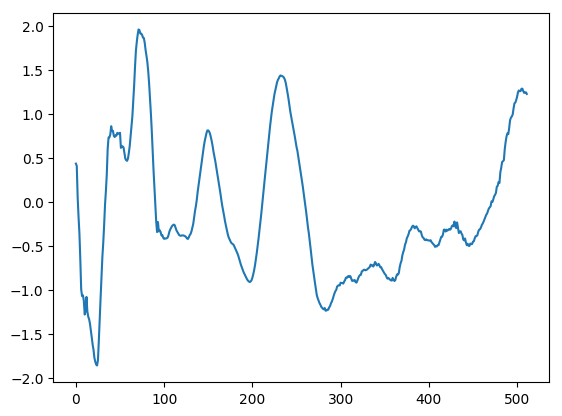

In [77]:
contact_events = []
distance_values = np.array([])
reduce_res_by = 4

for i in range(len(contact_signals)):
    cs = contact_signals.iloc[i, 2:101].tolist()
    contact_events.append(cs)
    ys = [contact_signals.distance[i]] * len(cs)
    distance_values = np.append(distance_values, ys)

contact_events = np.reshape(contact_events, [-1, 2048])
contact_events = [ x[::reduce_res_by] for x in contact_events ]

contact_events = StandardScaler().fit_transform(contact_events)

X_train, X_test, y_train, y_test = train_test_split(contact_events, 
                                                    distance_values, 
                                                    test_size=.33, 
                                                    random_state=42)
print('Data prepared:\n -- samples\t%d\n -- features\t%d\n -- test size\t%d\n -- train size\t%d' 
      % (len(contact_events), len(contact_events[0]), len(X_train), len(X_test)))
plt.plot(X_train[1])

In [78]:
weights = { 'W1' : tf.Variable(tf.random_normal([3, 1, 32])),
            'W2' : tf.Variable(tf.random_normal([3, 32, 32])),
            'W3' : tf.Variable(tf.random_normal([3, 32, 32])),
            'W4' : tf.Variable(tf.random_normal([3, 32, 32])),
            'W5' : tf.Variable(tf.random_normal([3, 32, 32])),
            'W6' : tf.Variable(tf.random_normal([3, 32, 32])),
            'W7' : tf.Variable(tf.random_normal([3, 32, 32])) }

def conv(in_features, kernel, stride=1):
    convolution = tf.nn.conv1d(in_features, kernel, stride=stride, padding='SAME')
    return tf.layers.max_pooling1d(convolution, 3, 2)
    

# build net
x = tf.placeholder(dtype=tf.float32, shape=[None, 512, 1])
y = tf.placeholder(dtype=tf.float32, shape=[None, 1])
#relative_y = tf.divide(y, 23.)
# window the input
#hann = tf.contrib.signal.hann_window(512, periodic=False, dtype=tf.float32, name=None)
#hann = tf.reshape(hann, shape=[-1, 512, 1])
#x_windowed = tf.multiply(x, hann)

conv1 = conv(x, weights['W1'], stride=2)
conv2 = conv(conv1, weights['W2'], stride=2)
#conv3 = conv(conv2, weights['W3'], stride=2)
#conv4 = conv(conv3, weights['W4'], stride=2)
#conv5 = conv(conv4, weights['W5'], stride=2)
#conv6 = conv(conv5, weights['W6'], stride=2)
#conv7 = conv(conv6, weights['W7'], stride=2)
print(conv2)
flaty = tf.layers.flatten(conv2)
print(flaty)
# output a percentage of antenna length


fc1   = fully_connected(flaty, 512, activation=tf.nn.relu)
fc2   = fully_connected(fc1, 512, activation=tf.nn.relu)
#fc1   = fully_connected(flaty, 128, activation=tf.nn.relu)
fc3   = fully_connected(fc2, 128, activation=tf.nn.relu)
#fc2   = fully_connected(fc1, 128, activation=tf.nn.relu)
sample   = fully_connected(fc3, 1, activation=tf.nn.relu)
#sample = out #tf.multiply(out, 23.)

loss = tf.losses.mean_squared_error(y, sample)
train = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

Tensor("max_pooling1d_1/Squeeze:0", shape=(?, 31, 32), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 992), dtype=float32)


Iteration 9 finished with mean error 0.36419
Iteration 19 finished with mean error 0.20635
Iteration 29 finished with mean error 0.17586
Iteration 39 finished with mean error 0.15729
Iteration 49 finished with mean error 0.10798
Accuracy	0.7015332197614992
Difference	0.3684854910598549
R2 Score	0.9888729793122342
Contact at 11.0 cm < - > 11.6895 cm prediction
Contact at 15.0 cm < - > 15.8042 cm prediction
Contact at 13.0 cm < - > 13.5316 cm prediction
Contact at 11.0 cm < - > 11.3350 cm prediction
Contact at 5.0 cm < - > 4.4084 cm prediction
Contact at 7.0 cm < - > 7.0464 cm prediction
Contact at 15.0 cm < - > 15.2434 cm prediction
Contact at 21.0 cm < - > 20.9734 cm prediction
Contact at 5.0 cm < - > 5.0369 cm prediction
Contact at 9.0 cm < - > 8.9341 cm prediction
Mean Divergence	0.3777170741714396


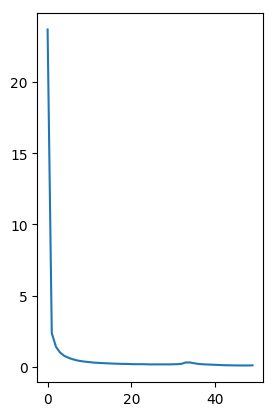

In [79]:
tf.set_random_seed(42)

EPOCHS = range(50)
BATCH_SIZE = 15
loss_summary = []

with tf.Session() as sess:
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in EPOCHS:
        epoch_mse = []
        for index, offset in enumerate(range(0, len(X_train), BATCH_SIZE)):
            xs = X_train[offset:offset+BATCH_SIZE]
            xs = np.reshape(xs, [len(xs), len(xs[0]), 1])
            ys = y_train[offset:offset+BATCH_SIZE]
            ys = np.reshape(ys, [len(ys), 1])
            _, mse = sess.run([train, loss], feed_dict={ x : xs, y : ys })
            epoch_mse.append(mse)
        if (i+1) % 10 == 0:
            print('Iteration {} finished with mean error {:.5f}'.format(i, np.mean(epoch_mse)))
        loss_summary.append(np.mean(epoch_mse))
    
    predictions = []

    X_test = np.reshape(X_test, [-1, len(X_test[0]), 1])
    y_test = np.reshape(y_test, [-1, 1])
    for i in range(len(X_test)):
        p = sess.run(sample, feed_dict={ x : [X_test[i]], y : [y_test[i]] })
        predictions.append(p)

    predictions = np.ravel(predictions)
    false_predictions = np.sum([ (p - t) > 0.2 for p, t in zip(predictions, y_test)  ])

    accuracy = float(len(predictions)) / float((len(predictions) + false_predictions))

    print('Accuracy\t{}'.format(accuracy))
    
    difference = np.mean(np.power(np.subtract(predictions, np.ravel(y_test)), 2))
    print('Difference\t{}'.format(difference))
    
    r2 = r2_score(np.ravel(y_test), predictions)
    print('R2 Score\t{}'.format(r2))
        
plt.subplot(1, 2, 1)
plt.plot(loss_summary)
for i in range(10):
    print("Contact at {} cm < - > {:.4f} cm prediction".format(np.ravel(y_test)[i], predictions[i]))
print("Mean Divergence\t{}".format(np.mean(np.abs(np.ravel(y_test) - predictions))))